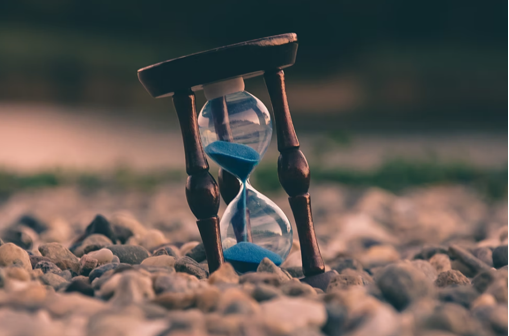
<br>Image Credit: [Aron Visuals](https://unsplash.com/@aronvisuals)


<p style="font-size:25px; color:#496595">Competition Purpose</p>

The purpose of the comeptiton is to predict sales for 1000s of products sold at favourite stores located in South America’s west coast **Ecuador**. If you want to know more about the company, gave a look [here](https://www.corporacionfavorita.com/en/)
<br>
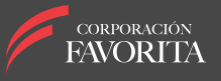

<br><p style="font-size:25px; color:#496595">Some information about the company</p>

Favorita Corporation and its commercial, industrial and real estate subsidiaries have a strong presence throughout the country. Its different lines of business and formats allows us to adapt our products, services and experiences offering to the local realities, according to your needs. Internationally, the Corporation’s subsidiaries have activities in six countries in the region, in addition to the ones in Ecuador.

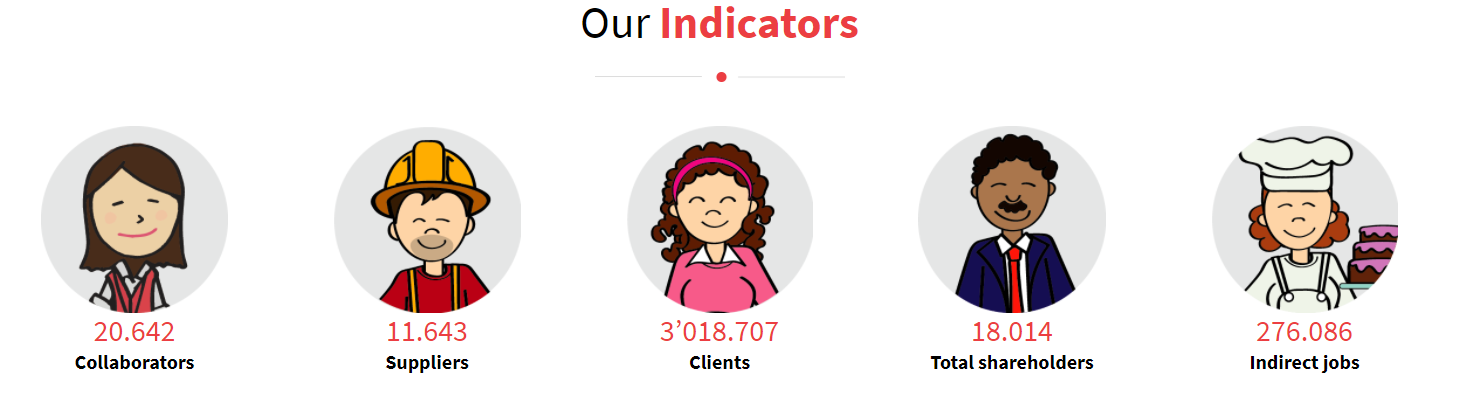

## Importing the library

In [1]:
import pandas as pd
import numpy as np
import calendar

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode(connected = True)
import os
import time
import itertools
import calendar as cal
import numpy as np 
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.signal import periodogram
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.stattools import pacf, acf

In [2]:
DATA_DIR = "/kaggle/input/store-sales-time-series-forecasting"

In [3]:
fig=go.Figure()
fig.add_trace(go.Scatter(
    x=[0, 1, 2, 3],
    y=[1.6, 1.6, 1.6, 1.6],
    mode="text", 
    text=["<span style='font-size:33px'><b>54</b></span>", 
          "<span style='font-size:33px'><b>33</b></span>",
          "<span style='font-size:33px'><b>16</b></span>",
          "<span style='font-size:33px'><b>56</b></span>"],
    textposition="bottom center"
))
fig.add_trace(go.Scatter(
    x=[0, 1, 2, 3],
    y=[1.1, 1.1, 1.1, 1.1],
    mode="text", 
    text=["Stores", "Products", "States", "Months"],
    textposition="bottom center"
))
fig.add_hline(y=2.2, line_width=5, line_color='gray')
fig.add_hline(y=0.3, line_width=3, line_color='gray')
fig.update_yaxes(visible=False)
fig.update_xaxes(visible=False)
fig.update_layout(showlegend=False, height=300, width=700, 
                  title='Store Sales Summary', title_x=0.5, title_y=0.9,
                  xaxis_range=[-0.5,3.6], yaxis_range=[-0.2,2.2],
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  font=dict(size=23, color='#323232'),
                  title_font=dict(size=35, color='#222'),
                  margin=dict(t=90,l=70,b=0,r=70), 
    )

## Dataset
> The data is about store sales forcasting where contaning 54 stores having 33 products in 16 states.<br>
📝 After combining the data we have ```df_train1``` dataset.

In [4]:
train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"), parse_dates=['date'])
test = pd.read_csv(os.path.join(DATA_DIR, "test.csv"), parse_dates=['date'])
oil = pd.read_csv(os.path.join(DATA_DIR, "oil.csv"), parse_dates=['date'])
holidays_events = pd.read_csv(os.path.join(DATA_DIR, "holidays_events.csv"), parse_dates=['date'])
transactions = pd.read_csv(os.path.join(DATA_DIR, "transactions.csv"), parse_dates=['date'])
stores = pd.read_csv(os.path.join(DATA_DIR, "stores.csv"))

print(f"Training Data: from {train.date.min()} to {train.date.max()} - {train.date.max() - train.date.min()}")
print(f"Testing Data: from {test.date.min()} to {test.date.max()} - {test.date.max() - test.date.min()}")

Training Data: from 2013-01-01 00:00:00 to 2017-08-15 00:00:00 - 1687 days 00:00:00
Testing Data: from 2017-08-16 00:00:00 to 2017-08-31 00:00:00 - 15 days 00:00:00


In [5]:
df_holi = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv')
df_oil = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv')
df_stores = pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv')
df_trans = pd.read_csv('../input/store-sales-time-series-forecasting/transactions.csv')

df_train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv')
df_test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv')

In [6]:
# copying of train data and merging other data
df_train1 = df_train.merge(df_holi, on = 'date', how='left')
df_train1 = df_train1.merge(df_oil, on = 'date', how='left')
df_train1 = df_train1.merge(df_stores, on = 'store_nbr', how='left')
df_train1 = df_train1.merge(df_trans, on = ['date', 'store_nbr'], how='left')
df_train1 = df_train1.rename(columns = {"type_x" : "holiday_type", "type_y" : "store_type"})

df_train1['date'] = pd.to_datetime(df_train1['date'])
df_train1['year'] = df_train1['date'].dt.year
df_train1['month'] = df_train1['date'].dt.month
df_train1['week'] = df_train1['date'].dt.isocalendar().week
df_train1['quarter'] = df_train1['date'].dt.quarter
df_train1['day_of_week'] = df_train1['date'].dt.day_name()
df_train1[:2]

,id,date,store_nbr,family,sales,onpromotion,holiday_type,locale,locale_name,description,...,city,state,store_type,cluster,transactions,year,month,week,quarter,day_of_week
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday


<h1 style="color:#496595"> Average Sales Analysis 📈 </h1>

In [7]:
# data
df_st_sa = df_train1.groupby('store_type').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)
df_fa_sa = df_train1.groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:10]
df_cl_sa = df_train1.groupby('cluster').agg({"sales" : "mean"}).reset_index() 
# chart color
df_fa_sa['color'] = '#496595'
df_fa_sa['color'][2:] = '#c6ccd8'
df_cl_sa['color'] = '#c6ccd8'

# chart
fig = make_subplots(rows=2, cols=2, 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3], vertical_spacing=0, horizontal_spacing=0.02,
                    subplot_titles=("Top 10 Highest Product Sales", "Highest Sales in Stores", "Clusters Vs Sales"))

fig.add_trace(go.Bar(x=df_fa_sa['sales'], y=df_fa_sa['family'], marker=dict(color= df_fa_sa['color']),
                     name='Family', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_st_sa['sales'], labels=df_st_sa['store_type'], name='Store type',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label'), 
                    row=1, col=2)
fig.add_trace(go.Bar(x=df_cl_sa['cluster'], y=df_cl_sa['sales'], 
                     marker=dict(color= df_cl_sa['color']), name='Cluster'), 
                     row=2, col=1)

# styling
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_cl_sa.cluster, ticktext=[i for i in range(1,17)], row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=500, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

<p style="font-size:19px">
    📌 <b>Interpret:</b><br><br>
    Highest sales are made by the products like grocery and beverages.<br>
    Store A has the highest sales which is 38%.
</p>

<h1 style="color:#496595"> Average Sales Analysis for Year-Month 📈 </h1>

In [8]:
# data 
df_2013 = df_train1[df_train1['year']==2013][['month','sales']]
df_2013 = df_2013.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s13'})
df_2014 = df_train1[df_train1['year']==2014][['month','sales']]
df_2014 = df_2014.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s14'})
df_2015 = df_train1[df_train1['year']==2015][['month','sales']]
df_2015 = df_2015.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s15'})
df_2016 = df_train1[df_train1['year']==2016][['month','sales']]
df_2016 = df_2016.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s16'})
df_2017 = df_train1[df_train1['year']==2017][['month','sales']]
df_2017 = df_2017.groupby('month').agg({"sales" : "mean"}).reset_index()
df_2017_no = pd.DataFrame({'month': [9,10,11,12], 'sales':[0,0,0,0]})
df_2017 = df_2017.append(df_2017_no).rename(columns={'sales':'s17'})
df_year = df_2013.merge(df_2014,on='month').merge(df_2015,on='month').merge(df_2016,on='month').merge(df_2017,on='month')

# top levels
top_labels = ['2013', '2014', '2015', '2016', '2017']

colors = ['rgba(38, 24, 74, 0.8)', 'rgba(71, 58, 131, 0.8)',
          'rgba(122, 120, 168, 0.8)', 'rgba(164, 163, 204, 0.85)',
          'rgba(190, 192, 213, 1)']

# X axis value 
df_year = df_year[['s13','s14','s15','s16','s17']].replace(np.nan,0)
x_data = df_year.values

# y axis value (Month)
df_2013['month'] =['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
y_data = df_2013['month'].tolist()

fig = go.Figure()
for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))

fig.update_layout(title='Avg Sales for each Year',
    xaxis=dict(showgrid=False, 
               zeroline=False, domain=[0.15, 1]),
    yaxis=dict(showgrid=False, showline=False,
               showticklabels=False, zeroline=False),
    barmode='stack', 
    template="plotly_white",
    margin=dict(l=0, r=50, t=100, b=10),
    showlegend=False, 
)

annotations = []
for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                          showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]
fig.update_layout(
    annotations=annotations)
fig.show()

<p style="font-size:19px;">
    📌 <b>Interpret:</b><br><br>
    Highest sales are made in December month and then decreases in January.<br>
    Sales are increasing gradually from 2013 to 2017.<br>
    <b>Note:</b> We don't have data for 2017: 9th to 12th month. 
</p>

<h1 style="color:#496595"> Average Sales Analysis: Time Series 📈 </h1>

In [9]:
# data
df_m_sa = df_train1.groupby('month').agg({"sales" : "mean"}).reset_index()
df_m_sa['sales'] = round(df_m_sa['sales'],2)
df_m_sa['month_text'] = df_m_sa['month'].apply(lambda x: calendar.month_abbr[x])
df_m_sa['text'] = df_m_sa['month_text'] + ' - ' + df_m_sa['sales'].astype(str) 

df_w_sa = df_train1.groupby('week').agg({"sales" : "mean"}).reset_index() 
df_q_sa = df_train1.groupby('quarter').agg({"sales" : "mean"}).reset_index() 
# chart color
df_m_sa['color'] = '#496595'
df_m_sa['color'][:-1] = '#c6ccd8'
df_w_sa['color'] = '#c6ccd8'

# chart
fig = make_subplots(rows=2, cols=2, vertical_spacing=0.08,
                    row_heights=[0.7, 0.3], 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3],
                    subplot_titles=("Month wise Avg Sales Analysis", "Quarter wise Avg Sales Analysis", 
                                    "Week wise Avg Sales Analysis"))

fig.add_trace(go.Bar(x=df_m_sa['sales'], y=df_m_sa['month'], marker=dict(color= df_m_sa['color']),
                     text=df_m_sa['text'],textposition='auto',
                     name='Month', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_q_sa['sales'], labels=df_q_sa['quarter'], name='Quarter',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label+percent'), 
                     row=1, col=2)
fig.add_trace(go.Scatter(x=df_w_sa['week'], y=df_w_sa['sales'], mode='lines+markers', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Week'), 
                     row=2, col=1)

# styling
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_w_sa.week, ticktext=[i for i in range(1,53)], 
                 row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=750, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

In [10]:
# data
df_dw_sa = df_train1.groupby('day_of_week').agg({"sales" : "mean"}).reset_index()
df_dw_sa.sales = round(df_dw_sa.sales, 2)

# chart
fig = px.bar(df_dw_sa, y='day_of_week', x='sales', title='Avg Sales vs Day of Week',
             color_discrete_sequence=['#c6ccd8'], text='sales',
             category_orders=dict(day_of_week=["Monday","Tuesday","Wednesday","Thursday", "Friday","Saturday","Sunday"]))
fig.update_yaxes(showgrid=False, ticksuffix=' ', showline=False)
fig.update_xaxes(visible=False)
fig.update_layout(margin=dict(t=60, b=0, l=0, r=0), height=350,
                  hovermode="y unified", 
                  yaxis_title=" ", template='plotly_white',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#c6ccd8", font_size=13, font_family="Lato, sans-serif"))

<p style="font-size:19px">📌 <b>Interpret:</b><br><br>
    As we saw in the above chart there is an upward trend in sales over the time. Although there are ups and downs at every point in time, generally we can observe that the trend increases. Also we can notice how the ups and downs seem to be a bit regular, it means we might be observing a seasonal pattern here too. Let’s take a closer look by observing some year’s data:<br>
    Highest sales are made on <b>Sunday</b>.<br>
    December month has the highest sales.<br>
    <b>Note:</b> We don't have data for 2017: 9th to 12th month. 
</p>

<h1 style="color:#496595"> Store Analysis </h1>

In [11]:
# data
df_st_ht = df_train1.groupby(['store_type','holiday_type']).agg({"sales" : "mean"}).reset_index()
df_st_ht['sales'] = round(df_st_ht['sales'], 2)

# chart
fig = px.scatter(df_st_ht, x='store_type', color='sales', y='holiday_type', size='sales',
                 color_discrete_sequence=px.colors.qualitative.D3,
                 title="Average Sales: Store Type Vs Holiday Type")
# styling
fig.update_yaxes(ticksuffix='  ')
fig.update_layout(height=400, xaxis_title='', yaxis_title='',
                  margin=dict(b=0),
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  title_font=dict(size=29, color='#444', family="Lato, sans-serif"),
                  font=dict(color='#555'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"))
fig.show()

In [12]:
# data
df_y_m_st = df_train1.groupby(['year','month','store_type']).agg({"sales" : "mean"}).reset_index()
df_y_m_st['sales'] = round(df_y_m_st['sales'], 2)

# chart
fig = px.scatter(df_y_m_st, x='month', y='store_type', color='sales', size='sales', 
                 facet_row='year', title='Average Sales: Store Type Vs Year(Month)')
# styling
fig.update_yaxes(ticksuffix='  ')
fig.update_xaxes(tickmode = 'array', tickvals=[i for i in range(1,13)], 
                 ticktext=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
fig.update_layout(height=900, xaxis_title='', yaxis_title='',
                  margin=dict(t=70, b=0),
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  title_font=dict(size=29, color='#444', family="Lato, sans-serif"),
                  font=dict(color='#555'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"))
fig.show()

In [13]:
# data
df_m_ht = df_train1.groupby(['month','holiday_type']).agg({"sales" : "mean"}).reset_index()
df_m_ht['sales'] = round(df_m_ht['sales'], 2)

# chart
fig = px.scatter(df_m_ht, x='month', color='sales', y='holiday_type', size='sales',
                 color_discrete_sequence=px.colors.qualitative.D3,
                 title="Average Sales: Month Vs Holiday Type")
# styling
fig.update_yaxes(ticksuffix='  ')
fig.update_xaxes(tickmode = 'array', tickvals=[i for i in range(1,13)], 
                 ticktext=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
fig.update_layout(height=400, xaxis_title='', yaxis_title='',
                  margin=dict(b=0),
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  title_font=dict(size=29, color='#444', family="Lato, sans-serif"),
                  font=dict(color='#555'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"))
fig.show()

<p style="font-size:19px">Most of the sales were done in Transfer Holiday and that to be in Christmas Holidays month December and January and pre-Christmas November month and May month showed a great trend in shopping.<br>
Let's take a closer look towards year and holidays type with sales. </p>

In [14]:
# data
df_y_m_ht = df_train1.groupby(['year','month','holiday_type']).agg({"sales" : "mean"}).reset_index()
df_y_m_ht['sales'] = round(df_y_m_ht['sales'], 2)

# chart
fig = px.scatter(df_y_m_ht, x='month', y='holiday_type', color='sales', size='sales', 
                 facet_row='year', title='Average Sales: Holiday_type Vs Year(Month)')
# styling
fig.update_yaxes(ticksuffix='  ')
fig.update_xaxes(tickmode = 'array', tickvals=[i for i in range(1,13)], 
                 ticktext=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
fig.update_layout(height=900, xaxis_title='', yaxis_title='',
                  margin=dict(t=70, b=0),
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  title_font=dict(size=29, color='#444', family="Lato, sans-serif"),
                  font=dict(color='#555'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"))
fig.show()

# **foreasing**

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import datetime
from learntools.time_series.style import *

from pathlib import Path
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go

comp_dir = Path('../input/store-sales-time-series-forecasting')
train = pd.read_csv(comp_dir / 'train.csv')
test = pd.read_csv(comp_dir / 'test.csv')
stores = pd.read_csv(comp_dir / 'stores.csv')
oil = pd.read_csv(comp_dir / 'oil.csv')
transactions =  pd.read_csv(comp_dir / 'transactions.csv')
holidays_events = pd.read_csv(comp_dir / 'holidays_events.csv')

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

In [16]:
df_data = pd.concat([train, test], sort=True)
df_data = df_data.merge(stores, how="left", on='store_nbr')   
df_data = df_data.merge(oil, how="left", on='date')      
df_data = df_data.merge(transactions, how="left", on=['date','store_nbr'])  
df_data = df_data.merge(holidays_events,on='date',how='left')
df_data = df_data.rename(columns={'type_x' : 'store_type','type_y':'holiday_type'})

df_data.date = pd.to_datetime(df_data.date)
df_data['year'] = df_data['date'].dt.year
df_data['month'] = df_data['date'].dt.month
df_data['week'] = df_data['date'].dt.isocalendar().week
df_data['quarter'] = df_data['date'].dt.quarter
df_data['day_of_week'] = df_data['date'].dt.day_name()
df_data.head()

,date,family,id,onpromotion,sales,store_nbr,city,state,store_type,cluster,...,holiday_type,locale,locale_name,description,transferred,year,month,week,quarter,day_of_week
0,2013-01-01,AUTOMOTIVE,0,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
1,2013-01-01,BABY CARE,1,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
2,2013-01-01,BEAUTY,2,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
3,2013-01-01,BEVERAGES,3,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
4,2013-01-01,BOOKS,4,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday


Text(0.5, 1.0, 'State vs Sales of Store A (per year)')

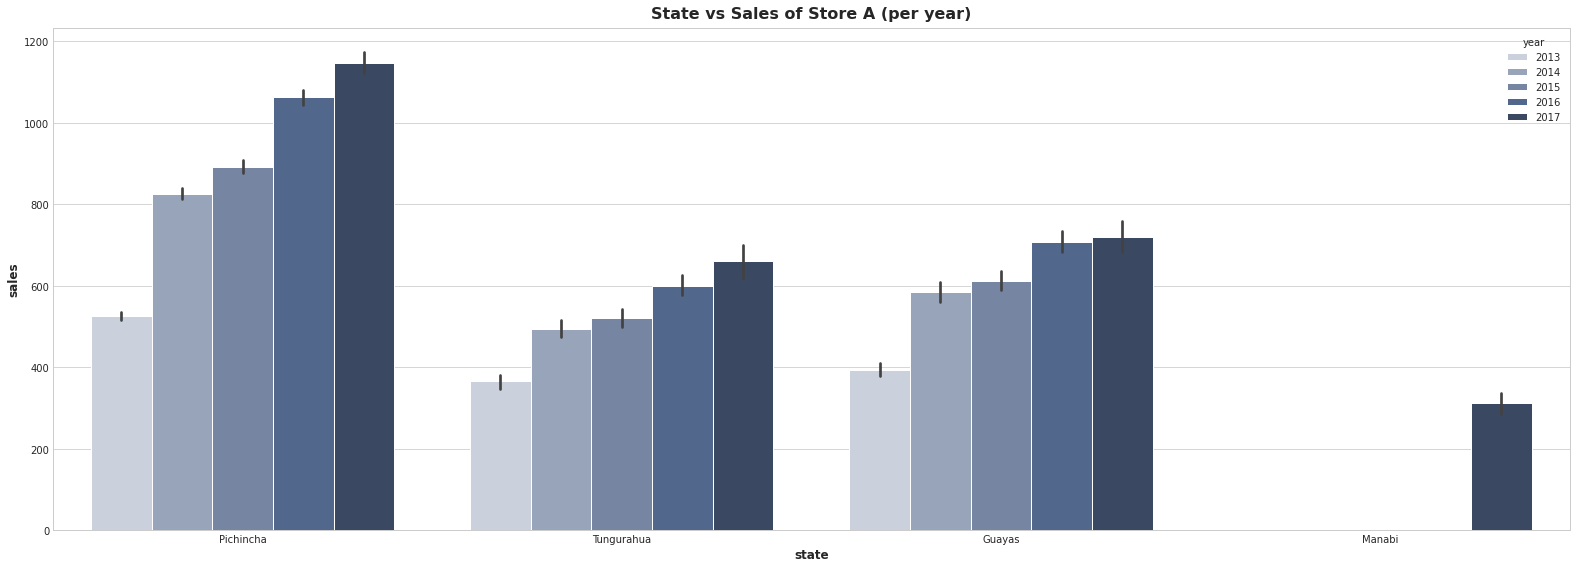

In [17]:
df_train = df_data[:train.shape[0]][['state','sales','store_type','year']]
fig = plt.figure(figsize=(22,8))
sns.set_style('whitegrid')
my_palette = ['#C8D0DF','#91A2BF','#6D83AA','#496595','#334668']
sns.barplot(x='state',y='sales',hue = 'year', palette = my_palette, data=df_train[df_train['store_type'] == 'A'])
plt.title("State vs Sales of Store A (per year)")

# Trend****

In [18]:
sales = df_data[:train.shape[0]].groupby('date').agg({"sales" : "mean"}).reset_index()
sales.set_index('date',inplace=True)
moving_average = sales.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)
moving_average['date'] = sales.index

fig = make_subplots(rows=1, cols=1, vertical_spacing=0.08,                    
                    subplot_titles=("Sales 365 - Day Moving Average"))
fig.add_trace(go.Scatter(x=sales.index, y=sales['sales'], mode='lines', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#334668'), name='365-Day Moving Average'))
fig.add_trace(go.Scatter(x=moving_average.date,y=moving_average.sales,mode='lines',name='Trend'))
fig.update_layout(height=350, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Sales trend during years",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

Text(0.5, 1.0, 'Seasonal Plot (year/dayofyear)')

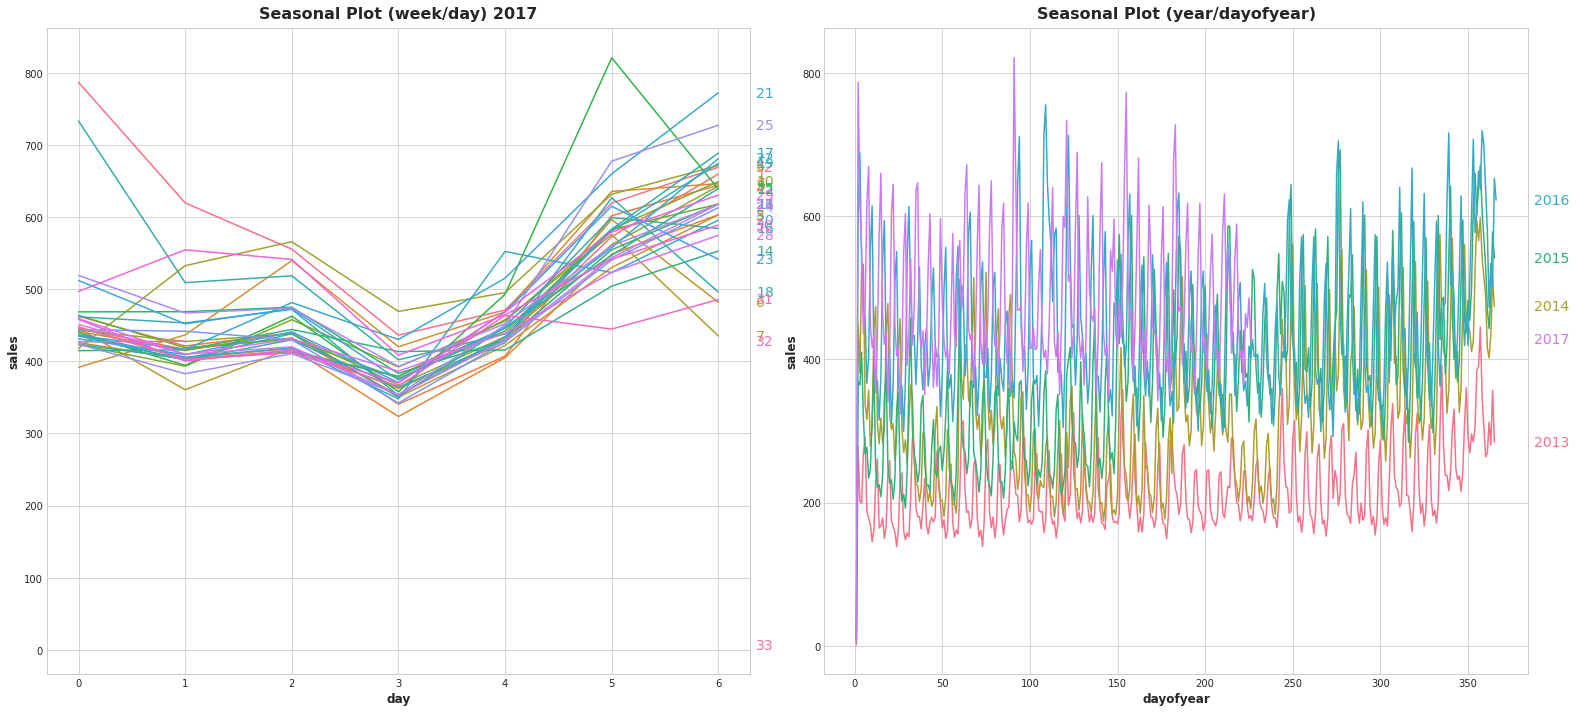

In [19]:
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    #.loc['2017']
)

X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
X['year'] = X.index.year
X['dayofyear'] = X.index.dayofyear
fig,(ax0,ax1) = plt.subplots(1, 2, figsize=(22, 10))
seasonal_plot(X.loc['2017'], y='sales', period="week", freq="day", ax=ax0)
ax0.set_title('Seasonal Plot (week/day) 2017')
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);
ax1.set_title('Seasonal Plot (year/dayofyear)')

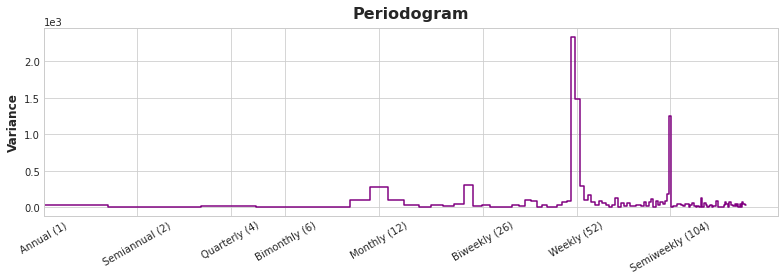

In [20]:
plot_periodogram(average_sales.loc['2017']);

# Decomposition****

<AxesSubplot:title={'center':'Noise'}, xlabel='date'>

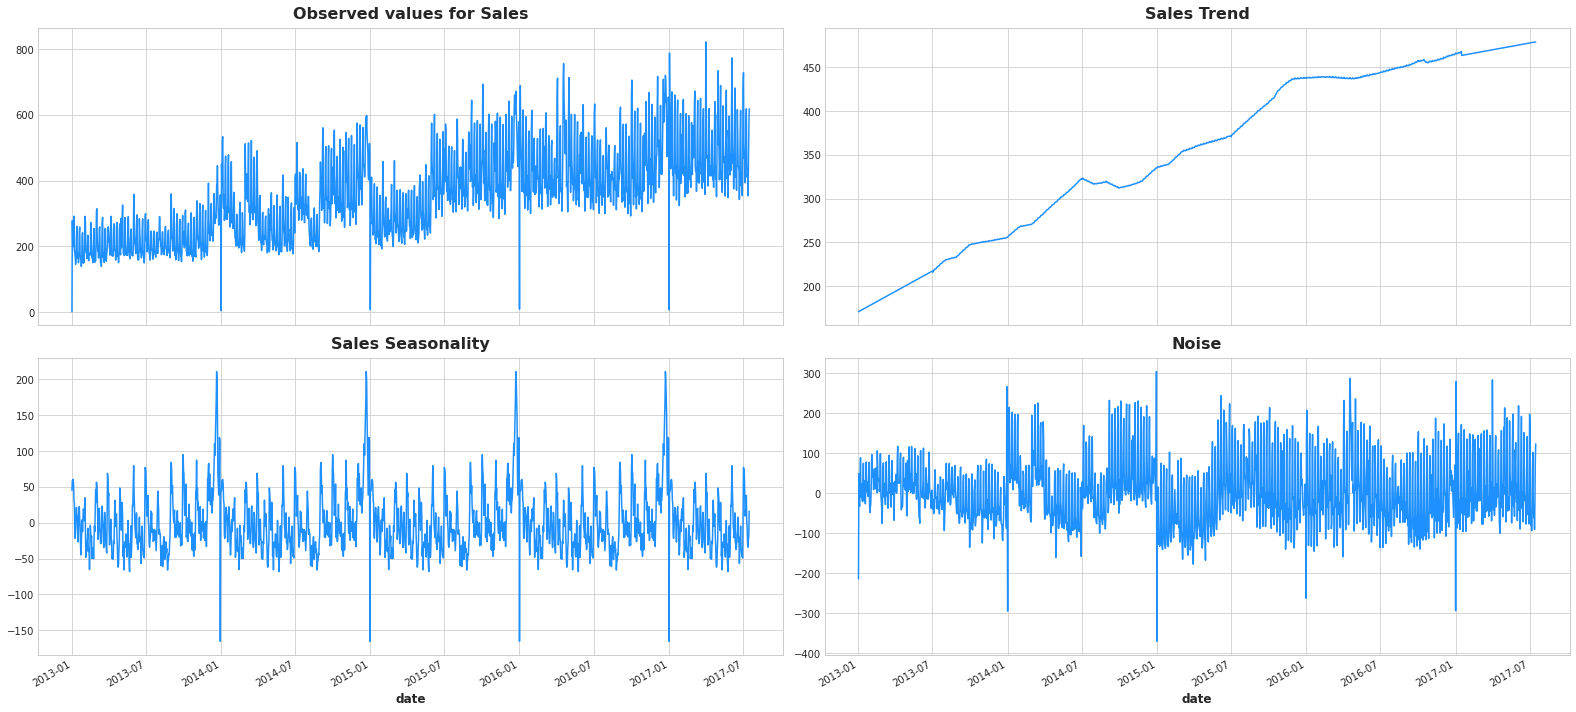

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(sales['sales'], period=365, model='additive', extrapolate_trend='freq')
fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(22,10))
ax[0,0].set_title('Observed values for Sales', fontsize=16)
decomp.observed.plot(ax = ax[0,0], legend=False, color='dodgerblue')

ax[0,1].set_title('Sales Trend', fontsize=16)
decomp.trend.plot(ax = ax[0,1],legend=False, color='dodgerblue')

ax[1,0].set_title('Sales Seasonality', fontsize=16)
decomp.seasonal.plot(ax = ax[1,0],legend=False, color='dodgerblue')

ax[1,1].set_title('Noise', fontsize=16)
decomp.resid.plot(ax = ax[1,1],legend=False, color='dodgerblue')

# Stationarity****

In [22]:
# check for stationarity
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    # .dropna() handles differenced data
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    # .to_string() removes the line "dtype: float64"
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [23]:
# Aggregating the Time Series to a monthly scaled index
y = df_data[['date','sales']].copy()
y.set_index('date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()
        
adf_test(y['sales'],title='') 

Augmented Dickey-Fuller Test: 
ADF test statistic      -1.581928
p-value                  0.492665
# lags used              1.000000
# observations          54.000000
critical value (1%)     -3.557709
critical value (5%)     -2.916770
critical value (10%)    -2.596222
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


<AxesSubplot:xlabel='date'>

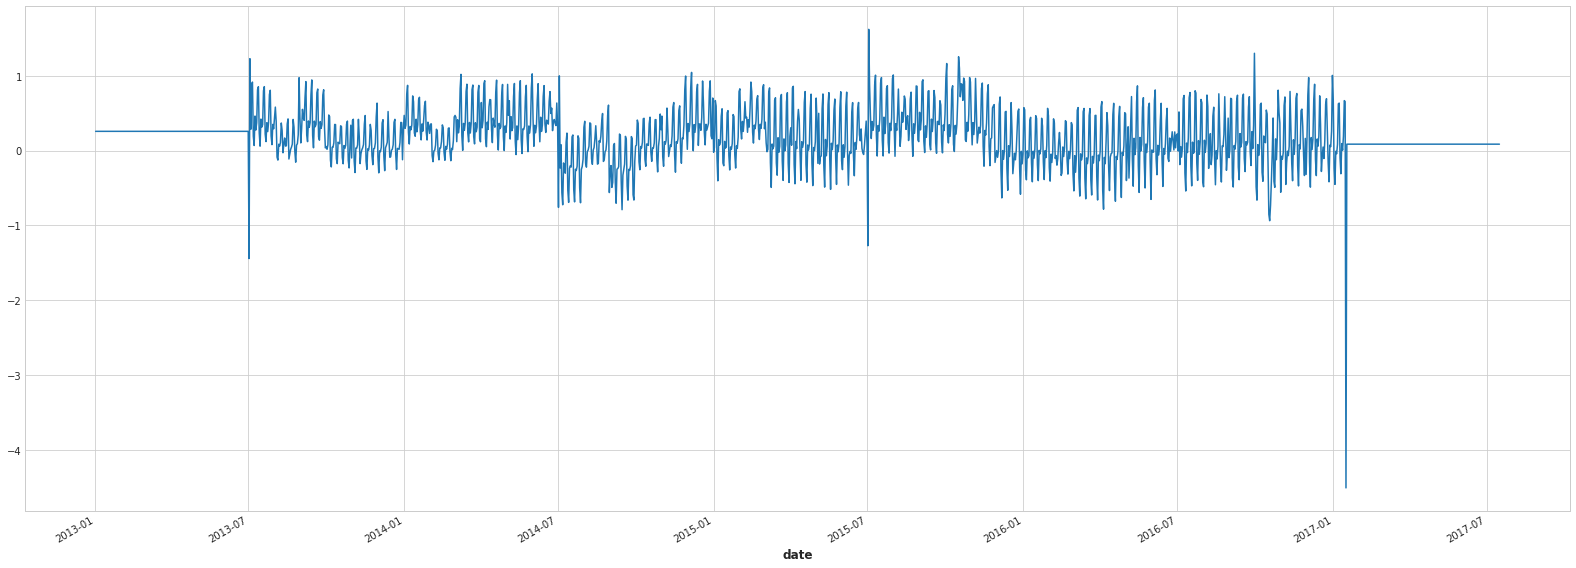

In [24]:
fig = plt.figure(figsize=(22,8))
decomp.trend.diff().plot()

Autocorrelation Analysis

# ModelingModelingFeature Transformation

# Modeling

In [25]:
from sklearn.model_selection import TimeSeriesSplit
N_SPLITS = 3

X = df_data['date']
y = df_data['sales']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
! pip install fbprophet
from fbprophet import Prophet

train = df_data[df_data['date']<= datetime.datetime(2017,8,15)][['date','sales']].groupby('date').mean().reset_index('date')
train.columns = ['ds', 'y']
x_valid = pd.DataFrame(df_data[df_data['date']>= datetime.datetime(2017,8,16)]['date'])
x_valid.columns = ['ds']

# Train the model
model = Prophet()
model.fit(train)
y_pred = model.predict(x_valid)

Initial log joint probability = -39.0776
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3507.45    0.00259348       181.497           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3509.55    0.00221969       87.8231      0.8702      0.8702      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3512.01   1.62474e-05       61.6131       0.231           1      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337        3512.4    0.00176412       115.964   2.264e-05       0.001      462  LS failed, Hessian reset 
     399        3512.7   6.94881e-06        77.574      0.2843           1      551   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3512.87   0.000171633    

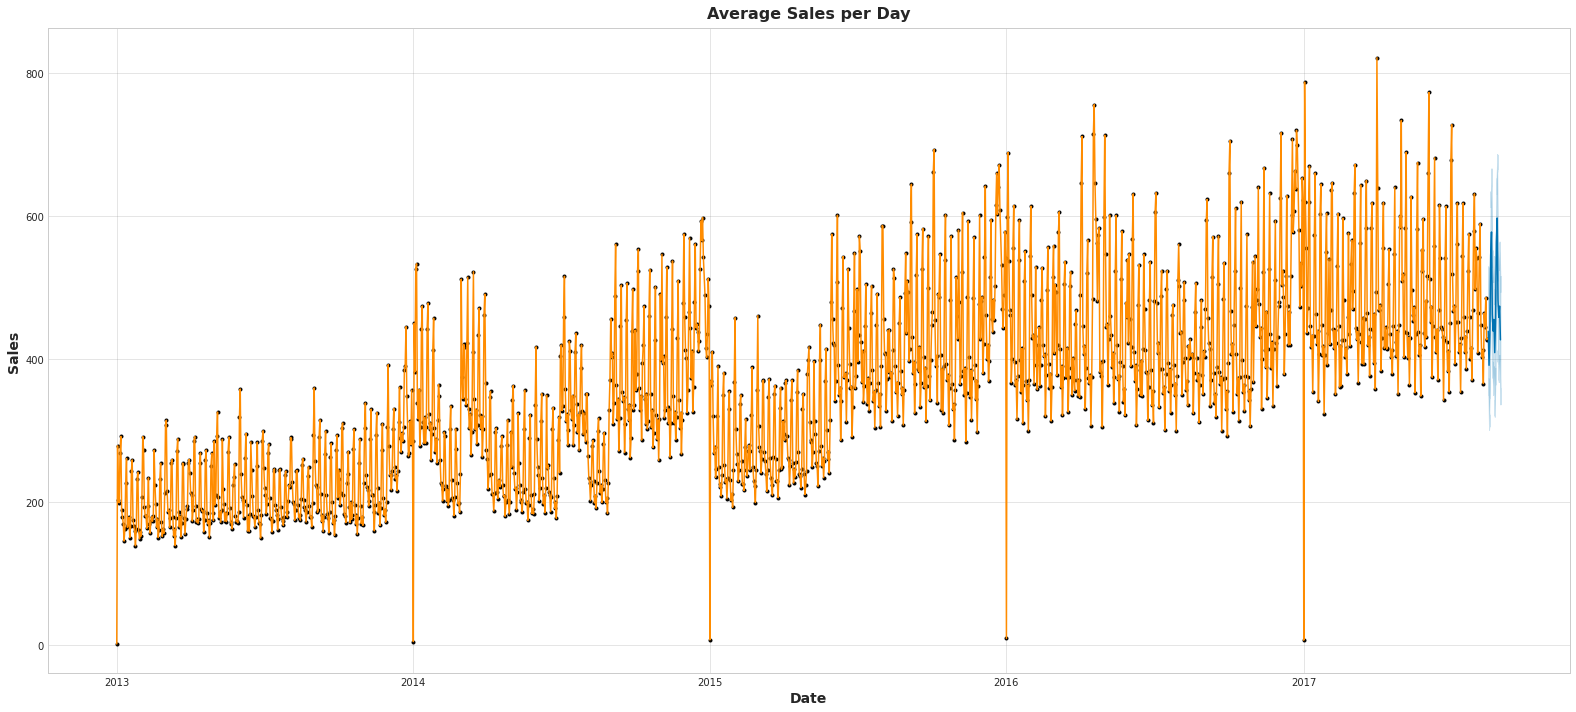

In [27]:
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(22)

model.plot(y_pred, ax=ax)
sns.lineplot(x=train['ds'], y=train['y'], ax=ax, color='darkorange') #navajowhite

#ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Sales', fontsize=14)
ax.set_title('Average Sales per Day')

plt.show()

# forecasting.

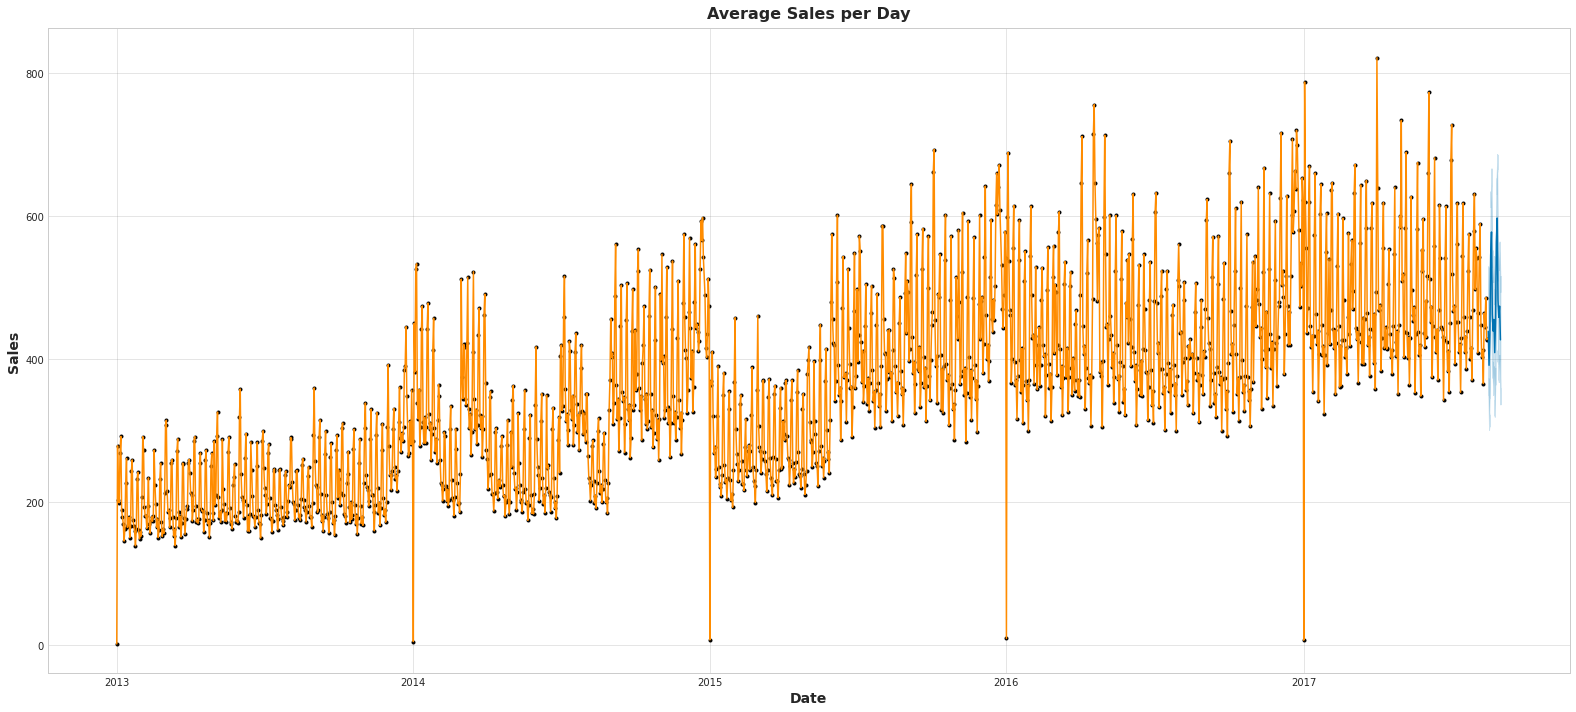

In [28]:
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(22)

model.plot(y_pred, ax=ax)
sns.lineplot(x=train['ds'], y=train['y'], ax=ax, color='darkorange') #navajowhite

#ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Sales', fontsize=14)
ax.set_title('Average Sales per Day')

plt.show()

Refrence:<br>
Big thanks to Shivam Bansal: [For merging the data](https://www.kaggle.com/shivamb/store-sales-forecasting-exploration)
<br>
<br>
# Show some love [Kaggle 2021 Survey Analysis](https://www.kaggle.com/kashishrastogi/reality-check-for-ds-ml-rs-students)

### If you like the charts do give a upvote. I will be adding more charts.